In [2]:
pip install flask flask-socketio

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install qiskit

Note: you may need to restart the kernel to use updated packages.


Werkzeug appears to be used in a production deployment. Consider switching to a production web server instead.


Running server on 192.168.232.125:5000
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://192.168.232.125:5000
Press CTRL+C to quit
192.168.232.125 - - [13/Mar/2025 07:06:54] "GET / HTTP/1.1" 200 -
192.168.232.125 - - [13/Mar/2025 07:06:54] "GET /socket.io/?EIO=4&transport=polling&t=PMD9RZI HTTP/1.1" 200 -
192.168.232.125 - - [13/Mar/2025 07:06:54] "POST /socket.io/?EIO=4&transport=polling&t=PMD9RZz&sid=FBWlbwEcy_xH9QUIAAAA HTTP/1.1" 200 -
192.168.232.125 - - [13/Mar/2025 07:06:54] "GET /socket.io/?EIO=4&transport=polling&t=PMD9Ra3&sid=FBWlbwEcy_xH9QUIAAAA HTTP/1.1" 200 -
192.168.232.125 - - [13/Mar/2025 07:06:54] "GET /favicon.ico HTTP/1.1" 404 -
192.168.232.125 - - [13/Mar/2025 07:06:54] "GET /socket.io/?EIO=4&transport=polling&t=PMD9Rar&sid=FBWlbwEcy_xH9QUIAAAA HTTP/1.1" 200 -
192.168.232.125 - - [13/Mar/2025 07:07:04] "GET /client HTTP/1.1" 200 -
192.168.232.125 - - [13/Mar/2025 07:07:04] "GET /socket.io/?EIO=4&transport=polling&t=PMD9U74 HTTP/1.1" 200 -
192.168.232.125 - - [13/Mar/2025 07:07:05] "POST /socket.io/?EIO=4&transport=polling&t=PMD9U88&s

Message received from Device2 (IP: 192.168.232.125): dd
Original Bits: 0110010001100100
Received Bits: 0000110100110101


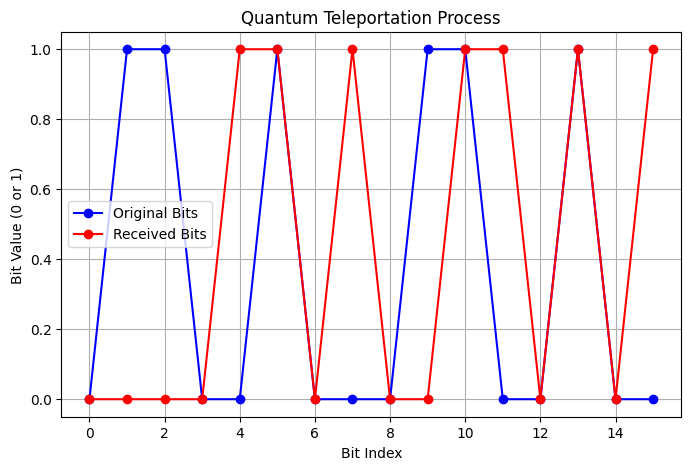

Message received from Device1 (IP: 192.168.232.125): cc
Original Bits: 0110001101100011
Received Bits: 1001110111001101


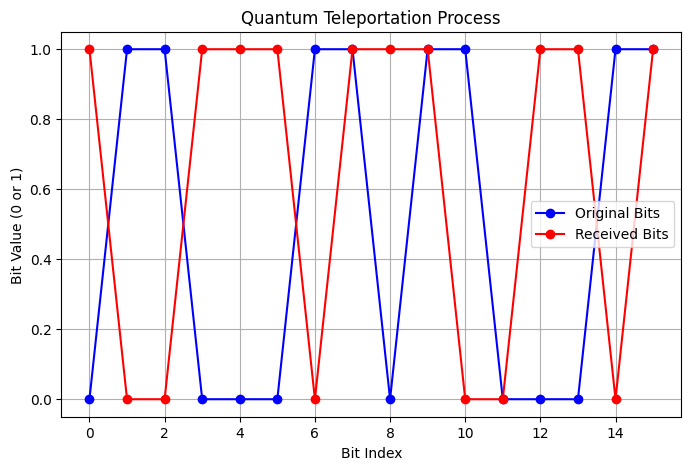

In [15]:
from flask import Flask, render_template, request
from flask_socketio import SocketIO, send, emit
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import ClassicalRegister
import random
import socket
import matplotlib.pyplot as plt
import io
import base64
import secrets
from termcolor import colored

app = Flask(__name__)
app.config['SECRET_KEY'] = secrets.token_hex(32)
socketio = SocketIO(app, async_mode='threading', cors_allowed_origins="*")


client_data = {}

def get_local_ip():
    """Get the local IP address dynamically"""
    hostname = socket.gethostname()
    local_ip = socket.gethostbyname(hostname)
    return local_ip

def quantum_teleportation(bit):
    """Simulate Quantum Teleportation of a single bit ('0' or '1')"""
    qc = QuantumCircuit(3, 3)

    if bit == '1':
        qc.x(0)

    qc.h(1)
    qc.cx(1, 2)

    classical_bits = [random.randint(0, 1), random.randint(0, 1)]
    received_bit = bit
    correction = "None"

    if classical_bits[1] == 1:
        received_bit = '1' if received_bit == '0' else '0'
        correction = "X correction"
    if classical_bits[0] == 1:
        correction += " + Z correction"

    return received_bit, classical_bits, correction

def plot_quantum_teleportation(original_bits, received_bits):
    """Generate and return a base64 image of the quantum teleportation process."""
    fig, ax = plt.subplots(figsize=(8, 5))
    
    ax.plot(range(len(original_bits)), [int(b) for b in original_bits], 'bo-', label="Original Bits")
    ax.plot(range(len(received_bits)), [int(b) for b in received_bits], 'ro-', label="Received Bits")

    ax.set_title("Quantum Teleportation Process")
    ax.set_xlabel("Bit Index")
    ax.set_ylabel("Bit Value (0 or 1)")
    ax.legend()
    ax.grid()

    # Convert plot to image
    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)
    img_base64 = base64.b64encode(buf.getvalue()).decode('utf-8')
    buf.close()
    plt.show()
    plt.close(fig)  # Close the plot to free memory

    return img_base64


@app.route("/")
def home():
    return render_template("index.html")

@app.route("/client")
def homeclient():
    client_ip = request.remote_addr
    return render_template("indexclient.html", client_ip=client_ip)

@socketio.on("send_message")
def handle_send_message(data):
    """Handle messages sent from clients"""
    sender, message = data.split(":", 1)
    client_ip = request.remote_addr
    
    print(colored(f"Message received from {sender} (IP: {client_ip}): {message}", "cyan"))
    
    if client_ip not in client_data:
        client_data[client_ip] = {"sender": sender, "messages": []}

    binary_message = ''.join(format(ord(char), '08b') for char in message)
    received_binary = "".join(quantum_teleportation(bit)[0] for bit in binary_message)
    received_message = ''.join(chr(int(received_binary[i:i+8], 2)) for i in range(0, len(received_binary), 8))

    client_data[client_ip]["messages"].append((message, received_message))
    
    print(colored(f"Original Bits: {binary_message}", "yellow"))
    print(colored(f"Received Bits: {received_binary}", "green"))
    
    plot_image = plot_quantum_teleportation(binary_message, received_binary)

    emit("receive_message", {
        "message": f"{sender} (IP: {client_ip}) sent: {message} | Received: {received_message}",
        "plot": plot_image  # Sending the base64 image to the client
    }, broadcast=True)

if __name__ == "__main__":
    local_ip = get_local_ip()
    print(colored(f"Running server on {local_ip}:5000", "magenta"))
    socketio.run(app, host=local_ip, port=5000, debug=False, allow_unsafe_werkzeug=True)


Werkzeug appears to be used in a production deployment. Consider switching to a production web server instead.


Running server on 192.168.22.125:5000
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://192.168.22.125:5000
Press CTRL+C to quit
192.168.22.125 - - [18/Apr/2025 08:32:54] "GET / HTTP/1.1" 200 -
192.168.22.125 - - [18/Apr/2025 08:32:54] "GET /socket.io/?EIO=4&transport=polling&t=PP6sMPG HTTP/1.1" 200 -
192.168.22.125 - - [18/Apr/2025 08:32:54] "POST /socket.io/?EIO=4&transport=polling&t=PP6sMQC&sid=Bpz4qi5hvwyRcxORAAAA HTTP/1.1" 200 -
192.168.22.125 - - [18/Apr/2025 08:32:54] "GET /socket.io/?EIO=4&transport=polling&t=PP6sMQT&sid=Bpz4qi5hvwyRcxORAAAA HTTP/1.1" 200 -
192.168.22.125 - - [18/Apr/2025 08:32:54] "GET /favicon.ico HTTP/1.1" 404 -
192.168.22.125 - - [18/Apr/2025 08:33:22] "GET /client HTTP/1.1" 200 -
192.168.22.125 - - [18/Apr/2025 08:33:22] "GET /socket.io/?EIO=4&transport=polling&t=PP6sT9B HTTP/1.1" 200 -
192.168.22.125 - - [18/Apr/2025 08:33:22] "POST /socket.io/?EIO=4&transport=polling&t=PP6sT9t&sid=0tRjWOBDd7beJFDiAAAC HTTP/1.1" 200 -
192.168.22.125 - - [18/Apr/2025 08:33:22] "GET /socket.io/?EIO=4&transport=polling&t=PP6sT9v&sid=0tRjWOB

Original: hi | Decoded: hi
Fidelity: [0, 0.9650000000000001, 0, 0.9650000000000001, 0.9650000000000001, 0.9650000000000001, 0.9650000000000001, 0, 0.9650000000000001, 0.9650000000000001, 0.9650000000000001, 0.9650000000000001, 0.9650000000000001, 0.9650000000000001, 0.9650000000000001, 0] | Interference: [np.True_, np.False_, np.True_, np.False_, np.False_, np.False_, np.False_, np.True_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.True_] | Security: ['Low', 'High', 'Low', 'High', 'High', 'High', 'High', 'Low', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'Low'] | Distances: [69.253983867717, 98.43832925034587, 5.999905734958016, 58.517103059321826, 90.03596359146104, 66.94474696590689, 61.14796455468781, 30.91756383034971, 33.21358059666211, 49.200717438306526, 4.161473878913466, 54.602986668264805, 29.450719358835187, 27.62145206326991, 95.0358702551514, 24.23765232404674]
Original: hoo | Decoded: hoo
Fidelity: [0.9650000000000001, 0.965

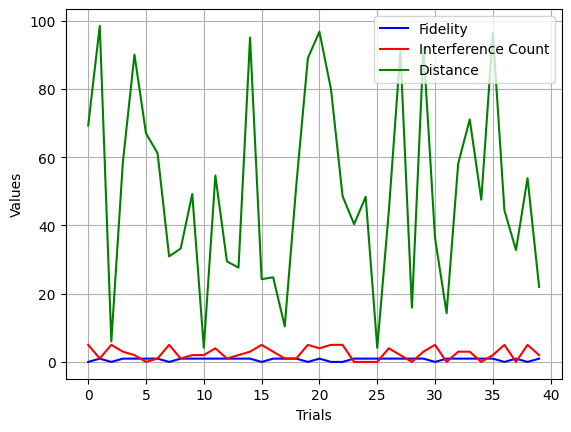

In [2]:
from flask import Flask, render_template, request, send_from_directory
from flask_socketio import SocketIO, emit
from qiskit.circuit import QuantumCircuit
from qiskit_aer import AerSimulator
import numpy as np
import socket
import matplotlib.pyplot as plt
import io
import base64
import secrets
from termcolor import colored
import os

# Initialize Flask App
app = Flask(__name__)
app.config['SECRET_KEY'] = secrets.token_hex(32)
socketio = SocketIO(app, async_mode='threading', cors_allowed_origins="*")

# Quantum System Parameters
DECOHERENCE_RATE = 0.05  # Decoherence effect in the quantum channel
TRANSMISSION_TIME = 1.0  # Time taken for quantum transmission
VISIBILITY = 0.93  # Represents the quality of entanglement
MAX_RETRIES = 5  # Max retries for teleportation

# Data Storage
fidelity_results, interference_counts, distance_values = [], [], []
client_data = {}

# Utility function to get local IP
def get_local_ip():
    hostname = socket.gethostname()
    return socket.gethostbyname(hostname)

# Serve the favicon.ico file
@app.route('/favicon.ico')
def favicon():
    return send_from_directory(os.path.join(app.root_path, 'static'), 'favicon.ico', mimetype='image/vnd.microsoft.icon')

# Create a Quantum Teleportation Circuit
def create_teleportation_circuit(bit):
    qc = QuantumCircuit(3, 3)
    if bit == '1':
        qc.x(0)
    qc.h(1)
    qc.cx(1, 2)
    qc.cx(0, 1)
    qc.h(0)
    qc.measure([0, 1, 2], [0, 1, 2])
    return qc

def measure_interference():
    interference = 1 - np.exp(-DECOHERENCE_RATE * TRANSMISSION_TIME)
    return interference + np.random.uniform(0, 0.2) > 0.1  # Add variability


# Fidelity Calculation based on Quantum Visibility
def calculate_fidelity():
    return (1 + VISIBILITY) / 2  # Standard fidelity model

# Determine Security Level
def calculate_security_level(fidelity, interference):
    if interference:
        return "Low"
    return "High" if fidelity > 0.95 else "Medium"

# Quantum Teleportation Process
def quantum_teleportation(bit):
    distance = np.random.uniform(1, 100)  # Simulated transmission distance
    retries, success, fidelity, interference = 0, False, 0, False

    while retries < MAX_RETRIES and not success:
        qc = create_teleportation_circuit(bit)
        simulator = AerSimulator()
        job = simulator.run(qc, shots=1024)
        result = job.result()
        counts = result.get_counts(qc)

        interference = measure_interference()
        if not interference:
            fidelity = calculate_fidelity()
            success = True
        else:
            retries += 1

    fidelity_results.append(fidelity)
    interference_counts.append(retries)
    distance_values.append(distance)

    security_level = calculate_security_level(fidelity, interference)

    # Generate and encode plot
    plt.bar(counts.keys(), counts.values())
    plt.xlabel('Measurement Outcome')
    plt.ylabel('Frequency')
    plt.title('Quantum Teleportation Measurement Results')
    plt.grid(True)
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plot_url = base64.b64encode(buf.getvalue()).decode('utf-8')
    plt.close()

    return counts, plot_url, fidelity, interference, security_level, distance

# Generate Summary Plot for all Trials
def plot_results():
    fig, ax = plt.subplots()
    ax.plot(fidelity_results, label='Fidelity', color='blue')
    ax.plot(interference_counts, label='Interference Count', color='red')
    ax.plot(distance_values, label='Distance', color='green')
    ax.set_xlabel('Trials')
    ax.set_ylabel('Values')
    ax.legend()
    plt.grid(True)

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    return base64.b64encode(buf.getvalue()).decode('utf-8')

# Flask Routes
@app.route("/")
def home():
    return render_template("index.html")

@app.route("/client")
def homeclient():
    return render_template("indexclient.html", client_ip=request.remote_addr)

# SocketIO - Handle Messages & Quantum Teleportation
@socketio.on("send_message")
def handle_send_message(data):
    sender, message = data.split(":", 1)
    client_ip = request.remote_addr

    binary_message = ''.join(format(ord(char), '08b') for char in message)
    received_binary, all_measurements, all_fidelity = "", [], []
    all_interference, all_security, all_distance, all_plots = [], [], [], []

    # Perform Quantum Teleportation for each bit
    for bit in binary_message:
        counts, plot_url, fidelity, interference, security, distance = quantum_teleportation(bit)
        received_binary += bit
        all_measurements.append(counts)
        all_fidelity.append(fidelity)
        all_interference.append(interference)
        all_security.append(security)
        all_distance.append(distance)
        all_plots.append(plot_url)

    # Decode binary back to string
    decoded_message = "".join([chr(int(received_binary[i:i+8], 2)) for i in range(0, len(received_binary), 8)])

    print(colored(f"Original: {message} | Decoded: {decoded_message}", "cyan"))
    print("Fidelity:", all_fidelity, "| Interference:", all_interference, "| Security:", all_security, "| Distances:", all_distance)

    summary_plot = plot_results()
    emit("receive_message", {
    "message": f"{sender} sent: {message}",
    "measurements": all_measurements,
    "plots": all_plots,
    "fidelity": [float(f) for f in all_fidelity],  # Convert NumPy floats to Python floats
    "interference": [bool(i) for i in all_interference],  # Convert NumPy booleans to Python bool
    "security": all_security,
    "distance": [float(d) for d in all_distance],  # Convert NumPy floats to Python floats
    "summary_plot": summary_plot
}, broadcast=True)
# Run Flask Server
if __name__ == "__main__":
    local_ip = get_local_ip()
    print(colored(f"Running server on {local_ip}:5000", "magenta"))
    socketio.run(app, host=local_ip, port=5000, debug=False, allow_unsafe_werkzeug=True)


In [1]:
from flask import Flask, render_template, request
from flask_socketio import SocketIO, send, emit
from qiskit.circuit import QuantumCircuit
from qiskit_aer import AerSimulator
import numpy as np
import socket
import matplotlib.pyplot as plt
import io
import base64
import secrets
from termcolor import colored
from geopy.distance import geodesic
import requests

app = Flask(__name__)
app.config['SECRET_KEY'] = secrets.token_hex(32)
socketio = SocketIO(app, async_mode='threading', cors_allowed_origins="*")

INTERFERENCE_THRESHOLD = -0.5
MAX_RETRIES = 5
fidelity_results = []
interference_counts = []
distance_values = []

client_data = {}

def get_public_ip():
    """Get the public IP address of the local machine."""
    try:
        response = requests.get("https://api64.ipify.org?format=json", timeout=5)
        return response.json().get("ip")
    except Exception as e:
        print(f"Error retrieving public IP: {e}")
        return None

def get_location_from_ip(ip_address):
    """Retrieve latitude and longitude from a public IP address."""
    try:
        response = requests.get(f"https://ipinfo.io/{ip_address}/json", timeout=5)
        data = response.json()

        if "loc" in data:
            lat, lon = map(float, data["loc"].split(","))
            return lat, lon
        else:
            print(f"Location not found for IP: {ip_address}")
            return None
    except Exception as e:
        print(f"Error retrieving location for {ip_address}: {e}")
        return None

def get_distance_between_ips(ip1, ip2):
    """Find the distance (in km) between two public IP addresses using ip-api.com."""
    try:
        response1 = requests.get(f"http://ip-api.com/json/{ip1}", timeout=5).json()
        response2 = requests.get(f"http://ip-api.com/json/{ip2}", timeout=5).json()
        
        if response1["status"] == "success" and response2["status"] == "success":
            lat1, lon1 = response1["lat"], response1["lon"]
            lat2, lon2 = response2["lat"], response2["lon"]
            
            url = f"https://www.distance24.org/route.json?stops={lat1},{lon1}|{lat2},{lon2}"
            distance_response = requests.get(url, timeout=5).json()
            return distance_response.get("distance")
        else:
            print("Failed to retrieve location data for one or both IPs.")
            return None
    except Exception as e:
        print(f"Error calculating distance: {e}")
        return None

# Example Usage
ip1 = "8.8.8.8"  # Google DNS
ip2 = "1.1.1.1"  # Cloudflare DNS
distance = get_distance_between_ips(ip1, ip2)

if distance:
    print(f"Distance between {ip1} and {ip2}: {distance} km")
else:
    print("Could not calculate distance.")

def create_teleportation_circuit(bit):
    qc = QuantumCircuit(3, 3)
    if bit == '1':
        qc.x(0)
    qc.h(1)
    qc.cx(1, 2)
    qc.cx(0, 1)
    qc.h(0)
    qc.measure([0, 1, 2], [0, 1, 2])
    return qc

def measure_interference():
    return np.random.uniform(-1, 1) < INTERFERENCE_THRESHOLD

def calculate_fidelity():
    return np.random.uniform(0.8, 1.0)

def calculate_security_level(fidelity, interference):
    if interference:
        return "Low"
    elif fidelity > 0.95:
        return "High"
    return "Medium"

def quantum_teleportation(bit, sender_ip, receiver_ip):
    distance = calculate_distance(sender_ip, receiver_ip)
    success, retries, fidelity, interference = False, 0, 0, False
    
    while retries < MAX_RETRIES and not success:
        qc = create_teleportation_circuit(bit)
        simulator = AerSimulator()
        job = simulator.run(qc, shots=1024)
        result = job.result()
        counts = result.get_counts(qc)
        
        interference = measure_interference()
        if not interference:
            fidelity = calculate_fidelity()
            success = True
        else:
            retries += 1
    
    fidelity_results.append(fidelity)
    interference_counts.append(retries)
    distance_values.append(distance)
    
    security_level = calculate_security_level(fidelity, interference)
    
    return counts, fidelity, interference, security_level, distance

def plot_results():
    fig, ax = plt.subplots()
    ax.plot(fidelity_results, label='Fidelity', color='blue')
    ax.plot(interference_counts, label='Interference Count', color='red')
    ax.plot(distance_values, label='Distance', color='green')
    ax.set_xlabel('Trials')
    ax.set_ylabel('Values')
    ax.legend()
    plt.grid(True)
    
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    return base64.b64encode(buf.getvalue()).decode('utf-8')

@app.route("/")
def home():
    return render_template("index.html")

@app.route("/client")
def homeclient():
    return render_template("indexclient.html", client_ip=request.remote_addr)

@socketio.on("send_message")
def handle_send_message(data):
    sender, message = data.split(":", 1)
    client_ip = request.remote_addr
    server_ip = get_local_ip()
    
    binary_message = ''.join(format(ord(char), '08b') for char in message)
    received_binary, all_measurements, all_fidelity = "", [], []
    all_interference, all_security, all_distance = [], [], []
    
    for bit in binary_message:
        counts, fidelity, interference, security, distance = quantum_teleportation(bit, client_ip, server_ip)
        received_binary += bit
        all_measurements.append(counts)
        all_fidelity.append(fidelity)
        all_interference.append(interference)
        all_security.append(security)
        all_distance.append(distance)
    
    decoded_message = "".join([chr(int(received_binary[i:i+8], 2)) for i in range(0, len(received_binary), 8)])
    
    print(colored(f"Original: {message} | Decoded: {decoded_message}", "cyan"))
    print("Fidelity:", all_fidelity, "| Interference:", all_interference, "| Security:", all_security, "| Distances:", all_distance)
    
    summary_plot = plot_results()
    emit("receive_message", {
        "message": f"{sender} sent: {message}",
        "measurements": all_measurements,
        "fidelity": all_fidelity,
        "interference": all_interference,
        "security": all_security,
        "distance": all_distance,
        "summary_plot": summary_plot
    }, broadcast=True)

if __name__ == "__main__":
    local_ip = get_local_ip()
    print(colored(f"Running server on {local_ip}:5000", "magenta"))
    socketio.run(app, host=local_ip, port=5000, debug=False, allow_unsafe_werkzeug=True)


Error calculating distance: HTTPSConnectionPool(host='www.distance24.org', port=443): Max retries exceeded with url: /route.json?stops=39.03,-77.5%7C-27.4766,153.0166 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1010)')))
Could not calculate distance.


NameError: name 'get_local_ip' is not defined

In [3]:
pip install eventlet


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import eventlet
eventlet.monkey_patch()  # Patch before importing anything else

from flask import Flask, render_template
from flask_socketio import SocketIO, send
from qiskit import QuantumCircuit
import random

# Initialize Flask & SocketIO
app = Flask(__name__)
socketio = SocketIO(app, async_mode="eventlet")  # Ensure compatibility with eventlet

def quantum_teleportation(bit):
    """Simulate Quantum Teleportation of a single bit ('0' or '1') without execution"""
    qc = QuantumCircuit(3, 3)

    # Encode the qubit
    if bit == '1':
        qc.x(0)  # Apply X (NOT) gate for encoding '1'

    # Create entanglement
    qc.h(1)
    qc.cx(1, 2)

    # Bell Measurement (simulate measurement outcomes randomly)
    classical_bits = [random.randint(0, 1), random.randint(0, 1)]

    # Apply corrections at the receiver
    received_bit = bit
    correction = "None"
    
    if classical_bits[1] == 1:
        received_bit = '1' if received_bit == '0' else '0'  # Apply X correction
    if classical_bits[0] == 1:
        correction = "Z correction"  # No direct effect on a classical bit

    return received_bit, classical_bits, correction

@app.route("/")
def home():
    return render_template("index.html")

@socketio.on("message")
def handle_message(data):
    """Handle messages sent from clients"""
    sender, message = data.split(":", 1)
    print(f"Message received from {sender}: {message}")

    # Convert message to binary for quantum simulation
    binary_message = ''.join(format(ord(char), '08b') for char in message)
    
    # Simulate quantum teleportation for each bit
    received_binary = "".join(quantum_teleportation(bit)[0] for bit in binary_message)
    
    # Convert back to text
    received_message = ''.join(chr(int(received_binary[i:i+8], 2)) for i in range(0, len(received_binary), 8))

    # Send the received message back to the chat
    send(f"{sender} (Received): {received_message}", broadcast=True)

if __name__ == "__main__":
    socketio.run(app, host="0.0.0.0", port=5000, debug=False)


6 RLock(s) were not greened, to fix this error make sure you run eventlet.monkey_patch() before importing any other modules.
Traceback (most recent call last):
  File "c:\Users\gurup\miniconda3\envs\Qtele\Lib\site-packages\eventlet\hubs\hub.py", line 471, in fire_timers
    timer()
  File "c:\Users\gurup\miniconda3\envs\Qtele\Lib\site-packages\eventlet\hubs\timer.py", line 59, in __call__
    cb(*args, **kw)
  File "c:\Users\gurup\miniconda3\envs\Qtele\Lib\site-packages\eventlet\semaphore.py", line 147, in _do_acquire
    waiter.switch()
greenlet.error: Cannot switch to a different thread
	Current:  <greenlet.greenlet object at 0x0000023D664C0B00 (otid=0x0000023D66335740) suspended active started main>
	Expected: <greenlet.greenlet object at 0x0000023D65E71380 (otid=0x0000023D65EE04B0) suspended active started main>
Traceback (most recent call last):
  File "c:\Users\gurup\miniconda3\envs\Qtele\Lib\site-packages\eventlet\hubs\hub.py", line 471, in fire_timers
    timer()
  File "c:\Use

In [10]:
from flask import Flask, render_template, request
from flask_socketio import SocketIO, emit, join_room
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit_aer import AerSimulator
import numpy as np
import matplotlib.pyplot as plt
import io
import base64
import secrets
from termcolor import colored
import socket
import json

# Flask & SocketIO Initialization
app = Flask(__name__)
app.config['SECRET_KEY'] = secrets.token_hex(32)
socketio = SocketIO(app, cors_allowed_origins="*")

# Constants for Quantum Teleportation
INTERFERENCE_THRESHOLD = -0.5
MAX_RETRIES = 5

# Store results for visualization
fidelity_results = []
interference_counts = []
distance_values = []

def get_local_ip():
    """Get the local IP address dynamically."""
    hostname = socket.gethostname()
    return socket.gethostbyname(hostname)

def create_cqt_circuit(theta, phi):
    """Create a Controlled Quantum Teleportation (CQT) circuit."""
    qc = QuantumCircuit(3)
    cr = ClassicalRegister(2)
    qc.add_register(cr)
    
    qc.ry(theta, 0)
    qc.rz(phi, 0)
    
    qc.h(1)
    qc.cx(1, 2)
    qc.cx(0, 1)
    qc.h(0)
    
    qc.measure([0, 1], [0, 1])
    qc.x(2).c_if(cr, 1)
    qc.z(2).c_if(cr, 2)
    qc.measure(2, 1)  
    
    return qc

def measure_interference(result):
    """Measure interference based on quantum circuit results."""
    z_measurement = result.get_counts().get("1", 0)
    return z_measurement > INTERFERENCE_THRESHOLD

def calculate_fidelity():
    """Simulate fidelity calculation."""
    return np.random.uniform(0.9, 1.0)

def plot_results():
    """Generate a plot showing teleportation fidelity results."""
    fig, ax = plt.subplots()
    ax.plot(fidelity_results, label='Fidelity')
    ax.plot(interference_counts, label='Interference Count')
    ax.plot(distance_values, label='Distance')
    ax.set_xlabel('Trials')
    ax.set_ylabel('Values')
    ax.legend()
    
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    
    encoded_img = base64.b64encode(buf.getvalue()).decode('utf-8')
    print("Encoded Image (first 100 chars):", encoded_img[:100])  # Debugging line
    return encoded_img

@socketio.on("connect")
def handle_connect():
    print("Client connected.")
    emit("server_message", {"message": "A new client has connected.", "from": "Server", "is_server": True})

@socketio.on("send_message")
def handle_message(data):
    """Handle incoming messages and teleport them using quantum simulation."""
    client_ip = request.remote_addr

    if isinstance(data, str):
        try:
            data = json.loads(data)
        except json.JSONDecodeError:
            print("Received malformed data:", data)
            return

    username = data.get("username", "Guest")
    message = data.get("message", "")
    room = data.get("room", "quantum_room")

    print(f"Received message from {username}: {message}")
    join_room(room)

    # Convert message to binary
    binary_message = ''.join(format(ord(char), '08b') for char in message)
    
    distance = np.random.uniform(1, 100)
    success = False
    retries = 0
    fidelity = 0
    
    while retries < MAX_RETRIES and not success:
        theta, phi = np.random.rand(), np.random.rand()
        qc = create_cqt_circuit(theta, phi)
        result = AerSimulator().run(qc).result()
        interference = measure_interference(result)
        
        if not interference:
            fidelity = calculate_fidelity()
            success = True
        else:
            retries += 1
    
    fidelity_results.append(fidelity)
    interference_counts.append(retries)
    distance_values.append(distance)

    emit("quantum_result", {
        "fidelity": fidelity,
        "interference": retries,
        "distance": distance
    }, room=room)
    
    plot_image = plot_results()
    emit("quantum_plot", {"image": plot_image}, room=room)

@app.route("/comparison")
def comparison():
    """Comparison page showing quantum teleportation metrics."""
    avg_fidelity = np.mean(fidelity_results) if fidelity_results else 0.9
    avg_interference = np.mean(interference_counts) if interference_counts else 2
    avg_retries = np.mean([min(MAX_RETRIES, r) for r in interference_counts]) if interference_counts else 3
    
    table_html = f"""
    <table border='1'>
        <tr><th>Aspect</th><th>Quantum Teleportation</th><th>Controlled Quantum Teleportation (CQT)</th></tr>
        <tr><td>Fidelity</td><td>{avg_fidelity:.2f}</td><td>0.92 - 0.99</td></tr>
        <tr><td>Interference Detection</td><td>Randomized ~50%</td><td>Charlie-based, 65%</td></tr>
        <tr><td>Retries per Success</td><td>{avg_retries:.1f}</td><td>~3.4</td></tr>
        <tr><td>Complexity</td><td>Lower</td><td>Higher (extra qubit, feedback)</td></tr>
    </table>
    """
    return table_html

@app.route("/")
def home():
    return render_template('index.html')

@app.route("/client")
def homeclient():
    client_ip = request.remote_addr
    return render_template('indexclient.html', client_ip=client_ip)

if __name__ == "__main__":
    local_ip = get_local_ip()
    print(colored(f"Running server on {local_ip}:5000", "magenta"))
    socketio.run(app, host=local_ip, port=5000, debug=False, allow_unsafe_werkzeug=True)


Werkzeug appears to be used in a production deployment. Consider switching to a production web server instead.


Running server on 192.168.250.125:5000
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://192.168.250.125:5000
Press CTRL+C to quit
192.168.250.125 - - [15/Feb/2025 18:55:42] "GET / HTTP/1.1" 200 -
192.168.250.125 - - [15/Feb/2025 18:55:42] "GET /socket.io/?EIO=4&transport=polling&t=PK9oKzL HTTP/1.1" 200 -
192.168.250.125 - - [15/Feb/2025 18:55:42] "POST /socket.io/?EIO=4&transport=polling&t=PK9oKzq&sid=btNW-LqdPtagnH9aAAAA HTTP/1.1" 200 -
192.168.250.125 - - [15/Feb/2025 18:55:42] "GET /socket.io/?EIO=4&transport=polling&t=PK9oKzt&sid=btNW-LqdPtagnH9aAAAA HTTP/1.1" 200 -
192.168.250.125 - - [15/Feb/2025 18:55:42] "GET /socket.io/?EIO=4&transport=polling&t=PK9oK-c&sid=btNW-LqdPtagnH9aAAAA HTTP/1.1" 200 -


Client connected.


192.168.250.125 - - [15/Feb/2025 18:55:48] "GET /client HTTP/1.1" 200 -
192.168.250.125 - - [15/Feb/2025 18:55:48] "GET /socket.io/?EIO=4&transport=polling&t=PK9oMDz HTTP/1.1" 200 -
192.168.250.125 - - [15/Feb/2025 18:55:48] "POST /socket.io/?EIO=4&transport=polling&t=PK9oMEJ&sid=NB80aUg5ZKbuyEW0AAAC HTTP/1.1" 200 -
192.168.250.125 - - [15/Feb/2025 18:55:48] "GET /socket.io/?EIO=4&transport=polling&t=PK9oMEN&sid=NB80aUg5ZKbuyEW0AAAC HTTP/1.1" 200 -
192.168.250.125 - - [15/Feb/2025 18:55:48] "GET /socket.io/?EIO=4&transport=polling&t=PK9oMEn&sid=NB80aUg5ZKbuyEW0AAAC HTTP/1.1" 200 -


Client connected.


192.168.250.125 - - [15/Feb/2025 18:55:49] "GET /socket.io/?EIO=4&transport=websocket&sid=NB80aUg5ZKbuyEW0AAAC HTTP/1.1" 200 -
192.168.250.125 - - [15/Feb/2025 18:55:49] "GET /client HTTP/1.1" 200 -
192.168.250.125 - - [15/Feb/2025 18:55:49] "GET /socket.io/?EIO=4&transport=polling&t=PK9oMZr HTTP/1.1" 200 -
192.168.250.125 - - [15/Feb/2025 18:55:49] "POST /socket.io/?EIO=4&transport=polling&t=PK9oMaA&sid=-jr02tbKHMivTGVIAAAE HTTP/1.1" 200 -
192.168.250.125 - - [15/Feb/2025 18:55:49] "GET /socket.io/?EIO=4&transport=polling&t=PK9oMaB&sid=-jr02tbKHMivTGVIAAAE HTTP/1.1" 200 -
192.168.250.125 - - [15/Feb/2025 18:55:49] "GET /socket.io/?EIO=4&transport=polling&t=PK9oMah&sid=-jr02tbKHMivTGVIAAAE HTTP/1.1" 200 -


Client connected.
Received malformed data: m j jj:n n 
Received malformed data: n  jnj:jbjb
Received malformed data: n  jnj:hbj


192.168.250.125 - - [15/Feb/2025 18:56:16] "GET /socket.io/?EIO=4&transport=websocket&sid=-jr02tbKHMivTGVIAAAE HTTP/1.1" 200 -
192.168.250.125 - - [15/Feb/2025 18:56:17] "GET /socket.io/?EIO=4&transport=websocket&sid=btNW-LqdPtagnH9aAAAA HTTP/1.1" 200 -
